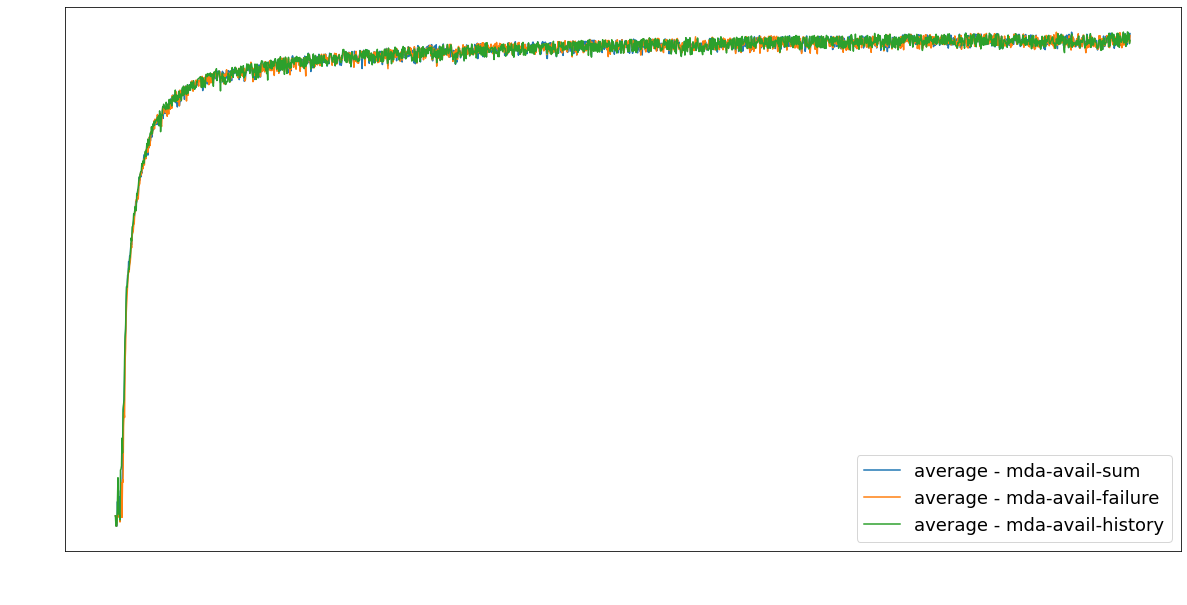

,average - mda-avail-failure,average - mda-avail-history,average - mda-avail-sum
finish_time,254351.016533,251614.664627,247189.446695
mean_acc,0.839224,0.840022,0.840223
std_acc,0.006751,0.006749,0.006586
avg_failed,0.125000,0.105500,0.090000
rounds_failed,234.000000,202.000000,170.000000
unique_participants,2800.000000,2753.000000,2771.000000


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import pandas as pd
import ast

plt.rcParams.update({
    'font.size': 18,
    'text.color': 'black',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white'
})
plt.figure(figsize=(20, 10))

data = {}


def extract_file_data(file):
    with open(file) as file:
        raw = file.read()
        failed = re.compile('Round \d+ failed clients: (\[[^]]*])').findall(raw)
        failed = list(map(len, map(ast.literal_eval, failed)))
        avg_failed = np.mean(failed)
        rounds_failed = len(list(filter(lambda x: x > 0, failed)))
        selected = re.compile('Sampled clients for round \d+: (\[[^]]*])').findall(raw)
        selected = list(map(ast.literal_eval, selected))
        unique_participants = len(set().union(*selected))
        return avg_failed, unique_participants, rounds_failed

base = 'results/'

for dir in os.listdir(base):
    config = ''
    with open(base + dir + '/args.txt') as args:
        args = args.read()
        config = re.compile('trace_distro = (\S+)').search(args).group(1)
        config += ' - ' + re.compile('selector = (\S+)').search(args).group(1)
        if 'mda' in config and 'score_method' in args:
            config += '-' + re.compile('score_method = (\S+)').search(args).group(1)

    accuracies = np.load(base + dir + '/accuracies.npy')
    for file in os.listdir(base + dir):
        if file.startswith('run.sh'):
            avg_failed, unique_participants, rounds_failed = extract_file_data(base + dir + '/' + file)

    plt.plot(range(len(accuracies)), accuracies, label=config)
    times = np.load(base + dir + '/times.npy')
    data[config] = {
        'finish_time': times[-1],
        'mean_acc': accuracies[1500:].mean(),
        'std_acc': accuracies[1500:].std(),
        'avg_failed': avg_failed,
        'rounds_failed': rounds_failed,
        'unique_participants': unique_participants
    }

plt.xlabel('Round number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

df = pd.DataFrame(data)
df
df.sort_index(axis=1)